# Calculate Dunning et al. seasonal characteristics on near-global CHIRPS data

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import re
import copy
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
import cmocean
from numba import jit as njit

from funcs_support import get_params, get_filepaths, nan_argmin_xr, nan_argmax_xr
from funcs_seasstats import wrapper_seasonal_stats
dir_list = get_params()

In [2]:
from distributed import Client
# Start dask client
client = Client()
display(client)

/home/kschwarz/.conda/envs/aa_thresh/lib/python3.13/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37037 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37037/status,
Dashboard: http://127.0.0.1:37037/status,Workers: 8
Total threads: 48,Total memory: 503.37 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41130,Workers: 0
Dashboard: http://127.0.0.1:37037/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35970,Total threads: 6
Dashboard: http://127.0.0.1:34398/status,Memory: 62.92 GiB
Nanny: tcp://127.0.0.1:46601,


In [3]:
subset_params = {'experiment_id':'historical',
                        'time':['1981-01-01','2025-09-30'],
                        'lat':[-50,50],
                        'lon':[-180,180],
                 'fn_suffix':''}
#wrapper_seasonal_stats(subset_params,
#                       mod_subset = ['CHIRPS'],
#                       silent=False)

In [4]:
mod_subset = ['CHIRPS']
import warnings
#mod_list = get_varlist(source_dir=dir_list['raw'],var=['pr'])
df = get_filepaths()
df = df.query('varname == "pr" and freq == "day"')
mod_list = np.unique(df.model.values)

mod_fns = dict()

if mod_subset is not None:
    mod_list = [mod for mod in mod_list if mod in mod_subset]

for mod in mod_list[:]: # For some reason without the [:] it randomly skips a few. No clue why. 
    #print(mod)
    hist_fns = df.query('model == "'+mod+'" and exp == "'+subset_params['experiment_id']+'"')
    hist_fns = hist_fns.path.values

    if len(hist_fns)==0:
        mod_list.remove(mod)
    else:
        if len(hist_fns)>1:
            warnings.warn('Model '+mod+' has more than one "'+subset_params['experiment_id']+'" file. Only the first, '+hist_fns[0]+', will be used.')
        mod_fns[mod]=hist_fns[0]

In [5]:
ds = xr.open_zarr(mod_fns['CHIRPS'])

In [6]:
ds['dayofyear'] = ds.time.dt.dayofyear
ds['year'] = ds.time.dt.year

In [7]:
# Drop leap years
ds_fft = ds.isel(time=ds.dayofyear<=365)
# Drop incomplete years (counting up to the last element that's 
# doy 365, representing the last full year in the sample
ds_fft = ds_fft.isel(time=slice(0,np.where(ds_fft.dayofyear==ds_fft.dayofyear.max())[0][-1]+1))

In [8]:
#--------------------------------------
# -- Calculate seasonal ratio 
# -- (power in annual : biannual freqs)
#--------------------------------------
def wrapper_seasratio(x):
    ''' nan-compatible wrapper for seasonal ratio calculation ''' 
    if np.any(np.isnan(x)):
        return np.nan
    else:
        ndays = len(x)
        # Get fourier transform
        fft = np.fft.fft(x)
    
        # Get ratio of power in annual to biannual frequencies
        seas_ratio = fft[int(ndays/365)] / fft[int(2*ndays/365)]
    
        # Return
        return seas_ratio

fft = xr.apply_ufunc(wrapper_seasratio,
                     ds_fft.pr,
                     input_core_dims = [['time']],
                     vectorize=True,
                     dask = 'parallelized')

seas_ratio = np.abs(fft.compute())

In [9]:
#--------------------------------------
# -- Calculate onset/demise of single-
# -- peaked regions
#--------------------------------------

# Calculate doy average (for some reason .groupby('time.dayofyear').mean()
# was either force computing or hanging elsewhere)
ds_doy = ds_fft.set_index(time=['dayofyear','year']).unstack().mean('year')

# Calculate A as above
C = (ds_doy.pr.cumsum('dayofyear') - ds_doy.pr.mean('dayofyear')*ds_doy.dayofyear)

C = C.compute()

# Calculate onset / demise of single-peaked seasonal regions as just the 
# min / max dayofyear of the cumulative anomaly
ds_seas = xr.merge([(nan_argmin_xr(C,dim='dayofyear')+1).to_dataset(name='onset'),
                    (nan_argmax_xr(C,dim='dayofyear')+1).to_dataset(name='demise')])
# Turn into dataset structure, labeling these onset/demise dates as the 
# dates for the first season in one place, leaving season 2 blank
ds_seas = ds_seas.expand_dims({'season':[1,2]})
ds_seas = ds_seas.where(ds_seas.season==1)

In [10]:
#--------------------------------------
# -- Calculate onset/demise of double-
# -- peaked regions
#--------------------------------------
wwidth = 30
# Get rolling average of C
# Smooth using 30-day running mean
C = (C.pad(dayofyear=int(wwidth/2),mode='wrap').
       rolling(dayofyear=wwidth,center=True).mean().
       dropna(dim='dayofyear',how='all').drop_duplicates('dayofyear'))
# Pad an extra 4 days, for searches of local max / minima
C = C.pad(dayofyear=4,mode='wrap')

# Save temporary zarr
tmp_fn = dir_list['tmp']+'C_smoothed_padded.zarr'
C.chunk({'dayofyear':-1,'lat':20,'lon':20}).to_dataset(name='C').to_zarr(tmp_fn)

In [29]:
tmp_fn = dir_list['tmp']+'C_smoothed_padded.zarr'

C = xr.open_zarr(tmp_fn).C.load()

# "Minima/maxima in the smoothed curve are detected by identifying days 
# where S(d) is lower/higher than the four preceding days and lower/higher 
# than the four following days (Figure 3a)."
n = 4
relmins = C == C.rolling(dayofyear=2*n+1,center=True).min()
relmaxs = C == C.rolling(dayofyear=2*n+1,center=True).max()

# For some reason the above chunks out the day of year into 372,1
#relmins = relmins.chunk({'dayofyear':-1})
#relmaxs = relmaxs.chunk({'dayofyear':-1})

In [18]:
def wrapper_get_bimodal_stats(dayofyear,rlmins,rlmaxs,seas_ratio,max_nseasons = 2):
    if np.all(~np.isnan(rlmins)) & (seas_ratio < 1):
        # Get onset / demise candidates as the days of year of relative
        # minima and maxima
        onset_candidates = dayofyear[rlmins]
        demise_candidates = dayofyear[rlmaxs]
        # Stack demise to allow for wrap arounds across the end of the year
        demise_candidates = np.hstack([demise_candidates,
                                       demise_candidates+365])
        
        # Broadcast potential onsets / demises against each other
        # Turning into floats to allow nans
        candidate_pairs = np.broadcast_arrays([onset_candidates.astype(float)],
                                                       np.transpose([demise_candidates.astype(float)]),                                      
                                             )
        # Creating deep copy, since np.broadcast_arrays creates views 
        # instead of copies
        candidate_pairs = copy.deepcopy(candidate_pairs)
        
        # Drop demises that wrap around to past the first demise of 
        # the calendar year to avoid double-counting
        candidate_pairs[1][candidate_pairs[1]>365] = np.where((candidate_pairs[1][candidate_pairs[1]>365] - 365) > np.min(demise_candidates),
                                                             np.nan,
                                                              candidate_pairs[1][candidate_pairs[1]>365])

        # Get duration of each onset / demise pair
        candidate_durations = candidate_pairs[1] - candidate_pairs[0]
        # Drop 'negative' durations (consequence of wraparound above)
        candidate_durations = np.where(candidate_durations>0,candidate_durations,np.nan)
        
        # Get index of demise for each onset
        demise_idxs = np.nanargmin(candidate_durations,0)
        
        # Seasons in onset, demise, duration form
        seasons = np.array([(candidate_pairs[0][de,on], candidate_pairs[1][de,on], candidate_durations[de,on]) for on,de in enumerate(demise_idxs)])
        
        # Pick longest seasons
        seasons = seasons[np.argsort(seasons[:,2])[-max_nseasons:None],:]
        
        # Sort by onset to be in calendrical order
        seasons = seasons[np.argsort(seasons[:,0]),:]
        
        # Separate out and return
        onset = seasons[:,0]
        demise = seasons[:,1]
        # demise = np.where(demise<365,demise,demise-365)
        duration = seasons[:,2]
    else:
        onset = demise = duration = np.array([np.nan]*max_nseasons)

    return onset,demise,duration

In [30]:
# Calculate bimodal points' seasonal stats
out=xr.apply_ufunc(wrapper_get_bimodal_stats,
                     relmins.dayofyear,
                       relmins,
                       relmaxs,
                       seas_ratio,
                       input_core_dims = (['dayofyear'],
                                          ['dayofyear'],
                                          ['dayofyear'],
                                          []),
                        output_core_dims = [['season'],['season'],['season']],
                       vectorize=True,
                   dask_gufunc_kwargs = {'output_sizes':{'season':2}},
                   output_dtypes = [float,float,float],
                    dask='parallelized')

# Add to seasonal ds
for idx,v in enumerate(['onset','demise']):
    ds_seas[v] = ds_seas[v].where(seas_ratio>1,out[idx])

ValueError: zero-size array to reduction operation minimum which has no identity

In [25]:
# Get duration (allowing for wrap-around seasons)
ds_seas['duration'] = xr.concat([np.abs(ds_seas.demise - ds_seas.onset),
                                   365-np.abs(ds_seas.demise - ds_seas.onset)],
                                  dim='order').min('order')

In [27]:
ds_seas = ds_seas.compute()

/home/kschwarz/.conda/envs/aa_thresh/lib/python3.13/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 225.23 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
2025-10-24 12:45:01,924 - distributed.worker - ERROR - Compute Failed
Key:       ('vectorize_wrapper_get_bimodal_stats-32a2cd6de0896b813c5dec9fe735b22d', 0, 0)
State:     executing
Task:  <Task ('vectorize_wrapper_get_bimodal_stats-32a2cd6de0896b813c5dec9fe735b22d', 0, 0) vectorize_wrapper_get_bimodal_stats(...)>
Exception: "ValueError('zero-size array to reduction operation minimum which has no identity')"
Traceback: '  File "/home/kschwarz/.conda/envs/aa_thresh/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py", line 2544, in __call__\n    return s

ValueError: zero-size array to reduction operation minimum which has no identity

In [25]:
@njit
def _season_stats_1d(pr, onset, demise):
    """Compute peak day, peak val, total rainfall for one location and one season."""
    if np.isnan(onset):
        return np.nan,np.nan,np.nan

    ndoy = pr.size
    onset_idx = int(onset) - 1
    demise_idx = int(demise) - 1
    if np.isnan(onset) or np.isnan(demise):
        return np.nan, np.nan, np.nan

    if demise_idx >= onset_idx:
        seas = pr[onset_idx:demise_idx+1]
        days = np.arange(onset_idx, demise_idx+1)
    else:
        # For wrap-around seasons
        seas = np.concatenate((pr[onset_idx:], pr[:demise_idx+1]))
        days = np.concatenate((np.arange(onset_idx, ndoy), np.arange(0, demise_idx+1)))

    # If season is empty, return nans
    if seas.size == 0:
        return np.nan, np.nan, np.nan

    argmax_local = np.argmax(seas)
    peak_day = days[argmax_local] + 1  # +1 to get day of year from python index
    peak_val = seas[argmax_local]
    total = np.sum(seg)
    return peak_day, peak_val, total

In [30]:
peak_timing, peak_amount, total_amount = xr.apply_ufunc(
        _season_stats_1d,
        ds_doy.pr,
        ds_seas.onset,
        ds_seas.demise,
        input_core_dims=[['dayofyear'], [], []],
        output_core_dims=[[], [], []],
        vectorize=True,      
        dask='parallelized',
        output_dtypes=[np.float32, np.float32, np.float32],
    )

In [36]:
ds_seas = xr.merge([ds_seas,
          peak_timing.to_dataset(name='peak_timing'),
          peak_amount.to_dataset(name='peak_amount'),
          total_amount.to_dataset(name='total_amount')])

In [37]:
# Average rainfall / day in season
ds_seas['avg_amount'] = ds_seas['total_amount'] / ds_seas['duration']

# What fraction of total rainfall for this location falls during this season
ds_seas['frac_totpr'] = ds_seas['total_amount'] / ds_doy.pr.sum('dayofyear')

In [39]:
ds_seas = ds_seas.compute()

/home/kschwarz/.conda/envs/aa_thresh/lib/python3.13/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 78.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
2025-10-24 12:31:12,619 - distributed.worker - ERROR - 
Traceback (most recent call last):
  File "/home/kschwarz/.conda/envs/aa_thresh/lib/python3.13/asyncio/runners.py", line 194, in run
    return runner.run(main)
           ~~~~~~~~~~^^^^^^
  File "/home/kschwarz/.conda/envs/aa_thresh/lib/python3.13/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "/home/kschwarz/.conda/envs/aa_thresh/lib/python3.13/asyncio/base_events.py", line 708, in run_until_complete
    self.run_fo

In [126]:
for v in ['peak_timing','peak_amount','total_amount']:
    ds_seas[v] = xr.zeros_like(ds_seas['onset']*np.nan)
    
for seas_idx in ds_seas.season.values:

    # For readability, get onsets, demises for that season
    onsets,demises = ds_seas.sel(season=seas_idx).onset,ds_seas.sel(season=seas_idx).demise

    # Generate blank seasonal belonging flag
    inseas_flag = xr.zeros_like(ds_doy.pr)
    
    # Get seasonal belonging flag for non-wrap-around seasons
    inseas_flag = inseas_flag.where(((demises > onsets) & 
                                       ((inseas_flag.dayofyear<onsets) | 
                                       (inseas_flag.dayofyear>demises))),
                                      1)
    # Get seasonal belonging flag for wrap-around seasons
    inseas_flag = inseas_flag.where(((demises > onsets) | 
                                     ((demises < onsets) & 
                                       ((inseas_flag.dayofyear<onsets) &
                                       (inseas_flag.dayofyear>demises)))),
                                      1)
    
    # Day of peak rainfall 
    ds_seas['peak_timing'].loc[{'season':seas_idx}] = nan_argmax_xr(ds_doy.where(inseas_flag).pr,dim='dayofyear')
    # Amount of peak rainfall
    ds_seas['peak_amount'].loc[{'season':seas_idx}] = ds_doy.where(inseas_flag).pr.max('dayofyear')
    # Total rainfall in season
    ds_seas['total_amount'].loc[{'season':seas_idx}] = ds_doy.where(inseas_flag).pr.sum('dayofyear')

/home/kschwarz/.conda/envs/aa_thresh/lib/python3.14/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 69.71 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
2025-10-24 11:55:48,639 - distributed.worker - ERROR - Compute Failed
Key:       ('vectorize_wrapper_get_bimodal_stats-c833aa8c60cc6358c412862b8072cce4', 49, 57)
State:     executing
Task:  <Task ('vectorize_wrapper_get_bimodal_stats-c833aa8c60cc6358c412862b8072cce4', 49, 57) vectorize_wrapper_get_bimodal_stats(...)>
Exception: "ValueError('zero-size array to reduction operation minimum which has no identity')"
Traceback: '  File "/home/kschwarz/.conda/envs/aa_thresh/lib/python3.14/site-packages/numpy/lib/_function_base_impl.py", line 2544, in __call__\n    retur

ValueError: zero-size array to reduction operation minimum which has no identity

In [83]:
# Average rainfall / day in season
ds_seas['avg_amount'] = ds_seas['total_amount'] / ds_seas['duration']

In [88]:
# What fraction of total rainfall for this location falls during this season
ds_seas['frac_totpr'] = ds_seas['total_amount'] / ds_doy.pr.sum('dayofyear')

In [96]:
if 'units' in ds.pr.attrs:
    unit_attrs = {'units':ds.pr.attrs['units']}
else:
    unit_attrs = {}

# Metadata and housekeeping
ds_seas['onset'].attrs = {'long_name':'seasonal onset','units':'day of year'}
ds_seas['demise'].attrs = {'long_name':'seasonal demise','units':'day of year'}
ds_seas['duration'].attrs = {'long_name':'seasonal duration','units':'days'}
ds_seas['peak_timing'].attrs = {'long_name':'day of peak rainfall','units':'day of year'}
ds_seas['peak_amount'].attrs = {'long_name':'peak rainfall amount',**unit_attrs}
ds_seas['total_amount'].attrs = {'long_name':'summed rainfall in season'}
ds_seas['avg_amount'].attrs = {'long_name':'avg. rainfall in season',**unit_attrs}
ds_seas['frac_totpr'].attrs = {'long_name':'season as frac. of total rainfall',**unit_attrs}

In [97]:
ds_seas.attrs['SOURCE'] = 'calculate_seasstats.ipynb'
ds_seas.attrs['DESCRIPTION'] = 'seasonal statistics calculated using the methodology from Dunning et al., 2017'

### old diag code

In [386]:
relmins_stack = relmins.stack(locv = ['lat','lon'])
relmaxs_stack = relmaxs.stack(locv = ['lat','lon'])
seas_ratio_stack = seas_ratio.stack(locv=['lat','lon'])

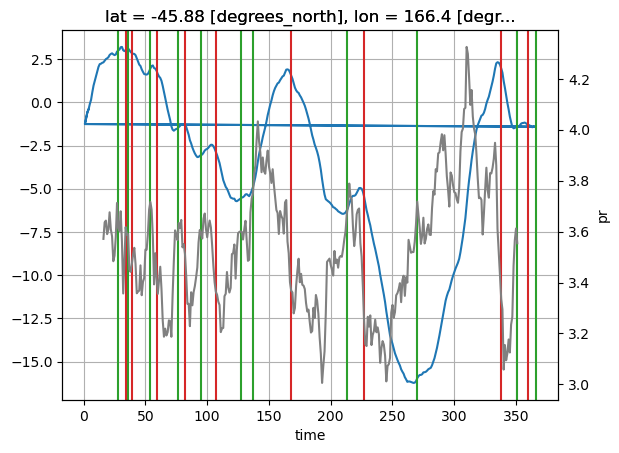

In [474]:
ax = plt.subplot()
C.sel({l:v for l,v in zip(['lat','lon'],tuple(np.atleast_1d(relmins_stack.locv[loc_idx].values))[0])}).plot()
for x in np.where(rlmins)[0]:
    ax.axvline(x,color='tab:green')
for x in np.where(rlmaxs)[0]:
    ax.axvline(x,color='tab:red')

ax.grid()

ax2 = ax.twinx()
(ds_doy.sel({l:v for l,v in zip(['lat','lon'],tuple(np.atleast_1d(relmins_stack.locv[loc_idx].values))[0])}).
    pr.rolling(dayofyear=wwidth,center=True).mean().plot(color='grey'))

In [ ]:
from tqdm import tqdm

for loc_idx in tqdm(np.arange(0,relmaxs_stack.sizes['locv'])):
    doy,rlmins,rlmaxs,sr = (relmins_stack.dayofyear.values,relmins_stack.isel(locv=loc_idx).values,
                            relmaxs_stack.isel(locv=loc_idx).values,seas_ratio_stack.isel(locv=loc_idx).values)
    wrapper_get_bimodal_stats(doy,
                              rlmins,
                              rlmaxs,
                              sr,
                              max_nseasons = 2)

In [15]:
import seaborn as sns

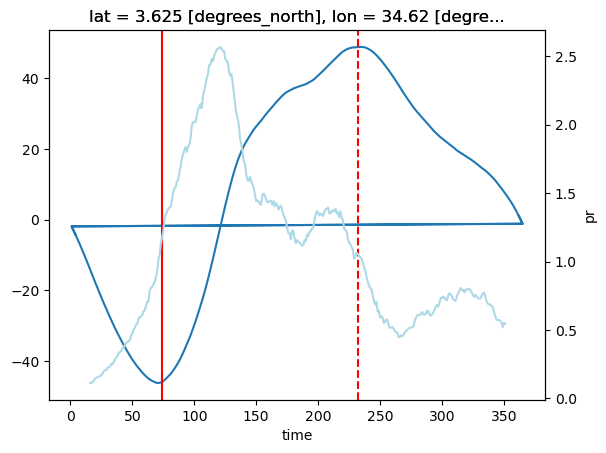

In [321]:
#subset_params = {'lat':-49.875,'lon':-74.375}
subset_params = {'lat':3.5,'lon':34.5,'method':'nearest'}
ax = plt.subplot()

C.sel(**subset_params).plot()
for seas_idx in np.arange(0,2):
    ax.axvline(out[0].sel(**subset_params).isel(season=seas_idx),color='k')
    ax.axvline(out[1].sel(**subset_params).isel(season=seas_idx),color='k',linestyle='--')
ax.axvline(ds_seas.onset.sel(**subset_params).isel(season=0),color='r')
ax.axvline(ds_seas.demise.sel(**subset_params).isel(season=0),color='r',linestyle='--')

ax2 = ax.twinx()
ds_doy.sel(**subset_params).rolling(dayofyear=wwidth,center=True).mean().pr.plot(color='lightblue')

In [306]:
np.abs(out[0].isel(season=0) - ds_seas.onset.isel(season=0)).stack(locv = ['lat','lon']).dropna('locv')[1]

<xarray.DataArray ()> Size: 8B
array(156.)
Coordinates:
    season   int64 8B 1
    locv     object 8B (np.float32(-49.875), np.float32(-74.375))
    lat      float32 4B -49.88
    lon      float32 4B -74.38

<Axes: xlabel='onset', ylabel='2seas'>

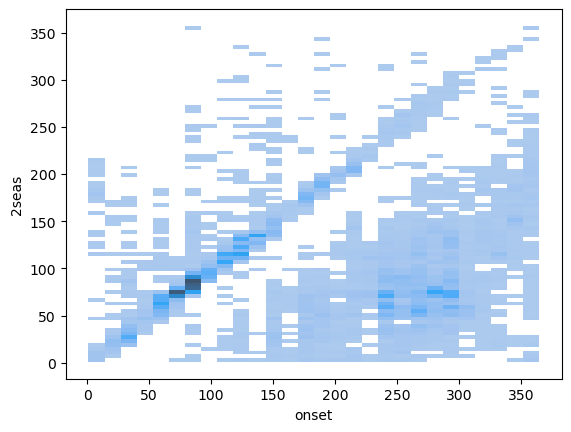

In [20]:
sns.histplot(out[0].isel(season=0).to_dataframe(name='2seas').join(ds_seas.onset.isel(season=0).to_dataframe()),
            x='onset',y='2seas')

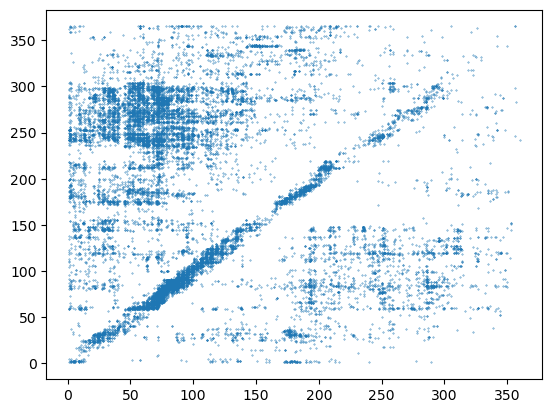

In [289]:
plt.scatter(out[0].isel(season=0),
            ds_seas.onset.isel(season=0),s=0.1)

<xarray.DataArray 'onset' (season: 2, lat: 400, lon: 1440)> Size: 9MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], shape=(2, 400, 1440))
Coordinates:
  * season   (season) int64 16B 1 2
  * lat      (lat) float32 2kB -49.88 -49.62 -49.38 -49.12 ... 49.38 49.62 49.88
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9

array([[280., 343.,  63.],
       [ 74., 138.,  64.]])

In [166]:
def wrapper_get_bimodal_stats(dayofyear,rlmins,rlmaxs,seas_ratio,max_nseasons = 2):
    if seas_ratio < 1:
        # Get onset / demise candidates as the days of year of relative
        # minima and maxima
        onset_candidates = dayofyear.where(rlmins, drop=True)
        demise_candidates = dayofyear.where(rlmaxs, drop=True)

        # Broadcast potential onsets / demises against each other
        candidate_pairs = xr.broadcast(onset_candidates.rename({'dayofyear':'onset'}),
                                       # Treat demises both explicitly, and one year into the future
                                       # to allow for seasons to wrap around the new year
                                     xr.concat([demise_candidates.rename({'dayofyear':'demise'}),
                                               (demise_candidates+365).rename({'dayofyear':'demise'})],
                                  dim='demise'))
        # Get duration of each onset / demise pair
        candidate_durations = (candidate_pairs[1] - candidate_pairs[0]).rename('duration')
        # Drop 'negative' durations (consequence of wraparound above)
        candidate_durations = candidate_durations.where(candidate_durations>0)
        
        # Select for each onset the next demise, wrapping if necessary
        seasons = candidate_durations.isel(demise=candidate_durations.argmin('demise'))
        
        # Get the longest max_nseasons seasons
        seasons = seasons[seasons.argsort()[0:max_nseasons].values]
        
        # Sort by onset to be in calendrical order
        seasons = seasons.sortby('onset')
        
        # Now turn into dataset with dimension season instead
        seasons = xr.Dataset({'onset': ('season', seasons['onset'].values.astype(int)),
                              'demise': ('season', seasons['demise'].values.astype(int)),
                              'duration': ('season', seasons.values.astype(int))},
                             coords={'season': np.arange(1,max_nseasons+1)})

        return seasons.onset,seasons.demise,seasons.duration

    else:
        # Otherwise, return a nan dataset
        seasons = xr.Dataset({'onset': ('season', [np.nan]*max_nseasons),
                              'demise': ('season', [np.nan]*max_nseasons),
                              'duration': ('season', [np.nan]*max_nseasons)},
                             coords={'season': np.arange(1,max_nseasons+1)})
        return seasons.onset,seasons.demise,seasons.duration

In [ ]:
onset,demise,duration=xr.apply_ufunc(wrapper_get_bimodal_stats,
                                     relmins.dayofyear,
                                       relmins,
                                       relmaxs,
                                       seas_ratio,
                                       input_core_dims = (['dayofyear'],
                                                          ['dayofyear'],
                                                          ['dayofyear'],
                                                          []),
                                        output_core_dims = [['season'],['season'],['season']],
                                       vectorize=True)

In [152]:
subset_params = {'lat':3,'lon':10,'method':'nearest'}

wrapper_get_bimodal_stats(relmins.sel(**subset_params),
                          relmaxs.sel(**subset_params),
                          seas_ratio.sel(**subset_params))

<xarray.Dataset> Size: 64B
Dimensions:   (season: 2)
Coordinates:
  * season    (season) int64 16B 1 2
Data variables:
    onset     (season) int64 16B 87 223
    demise    (season) int64 16B 165 319
    duration  (season) int64 16B 78 96

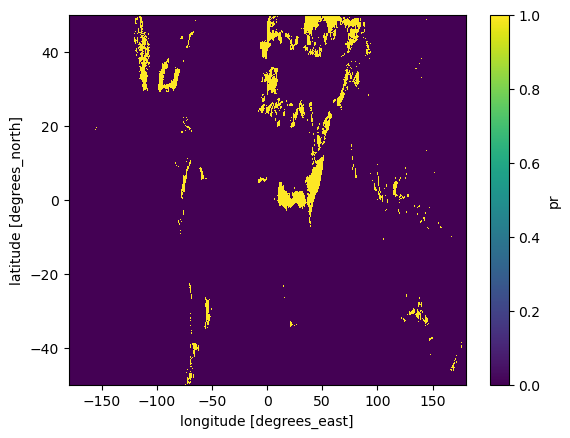

In [145]:
(np.abs(fft)<1).plot()

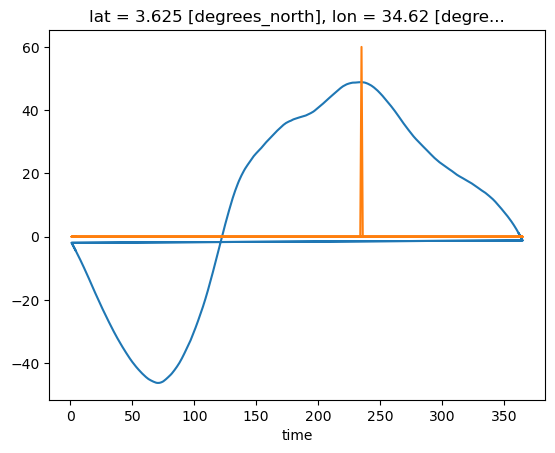

In [135]:
c = C.sel(lat=3.5,lon=34.5,method='nearest')

n = 4
c.plot()
((c == c.rolling(dayofyear=2*n+1,center=True).max())*60).plot()

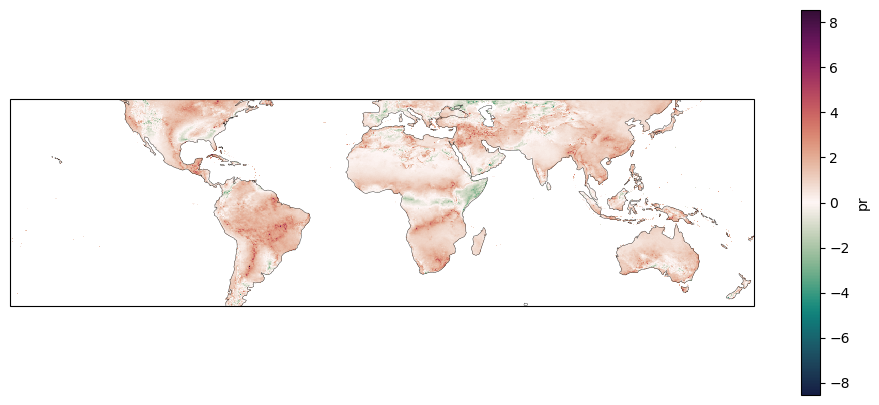

In [21]:
fig =plt.figure(figsize=(12,5))
ax = plt.subplot(projection=ccrs.PlateCarree())
np.log(np.abs(fft)).plot(cmap=cmocean.cm.curl,transform=ccrs.PlateCarree())
ax.coastlines(linewidth=0.25)